# DCGAN
## Introduction


Generative Adversarial Networks are an unsupervised deep learning method that learns the underlying distribution of training data and can then generate data with the same distribution.

GANs are composed of a generator and discriminator. The generator takes latent space vector sampled from a standard normal distribution and generates data with the same distribution as the training data by mapping the latent space vector into that data space. The discriminator is a binary classify that takes an image as an input and outputs the probability of that image being real of fake (generated by the generator). 

The generator and discriminator play a minmax game where the discriminator tries to maximize the probability to correctly classify real and fake images $logD(x)$ , and the generator tries to minimize the probability that the discriminator will predict fake images as fakes ($log(1-D(G(z)))$.

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}





In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torchvision import datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils


device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

In [ ]:
!pip install tensorboardX
!pip install tensorboardX --no-cache-dir
!pip install tensorboard 


In [ ]:
from tensorboardX import SummaryWriter 
writer = SummaryWriter('runs_mnist')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs_mnist

# Load MNIST dataset

In [ ]:
batch_size_train = 128

# define dataset preprocessing
transform = transforms.Compose([
    # resize
    transforms.Resize(64),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize((0.5), (0.5))
])

# create dataloader and fetch mnist dataset
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('/files/', train=True, download=True, transform=transform),
  batch_size=batch_size_train, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



# Visualize dataset

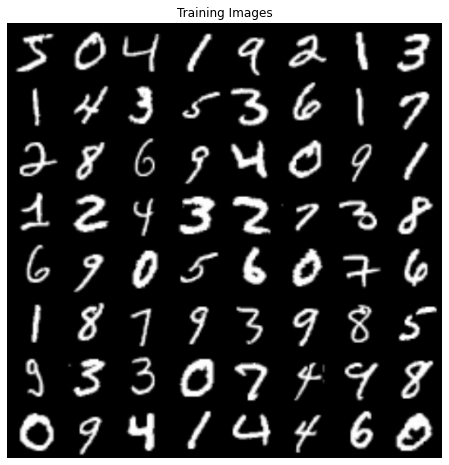

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model definition

# Generator
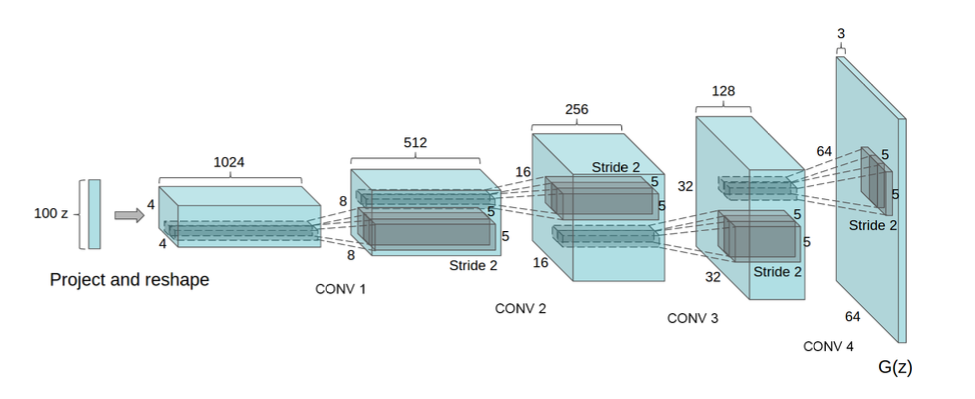

The generator maps the latent space z to the data space using strided two diemensional convolutional transpose layers, followed by batch normalization and ReLu activation function. The last layer of the generator is passed trhough a tanh function to map the data to [-1,1] range. 



*   Convolutional transpose layers
> Convolutional transpose layers is an upsampling technique to go from an input feature map to the desired dimension of an output feature map.





*   Batch normalization
>Stabilizes the learning by normalizing the input to each unit to have zero mean and unit variance. It prevents mode collapse or issues due to poor initialization. Batchnorm was not applied to the generator output layer and discriminator input layer.

*   ReLu
>Piecewise linear function that outputs the input for values larger than zero and zero for values below zero. Overcomes vanishing gradient problem.




In [ ]:
class Generator(torch.nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.conv0 = nn.Sequential(nn.ConvTranspose2d(in_channels = 100, out_channels = 512, stride = 1, kernel_size = 4, padding = 0, bias =False),
                               nn.BatchNorm2d(512),
                               nn.ReLU())
    self.conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels = 512, out_channels = 256, stride = 2, kernel_size = 4, padding = 1, bias =False),
                               nn.BatchNorm2d(256),
                               nn.ReLU())
    self.conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels = 256, out_channels = 128, stride = 2, kernel_size = 4, padding = 1, bias =False),
                               nn.BatchNorm2d(128),
                               nn.ReLU())   
    self.conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels = 128, out_channels = 64, stride = 2, kernel_size = 4, padding = 1, bias =False),
                               nn.BatchNorm2d(64),
                               nn.ReLU())      
    self.conv4 = nn.Sequential(nn.ConvTranspose2d(in_channels = 64, out_channels = 1, stride = 2, kernel_size = 4, padding = 1, bias=True),
                             )
    self.out = torch.nn.Tanh()
  def forward(self, x):
    x = self.conv0(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.out(x)
    return x
    

# Discriminator

The discriminator takes and input image and outputs a probability to what class in belongs. It is using a series of 2D convolutions foolowed by batch norm and LeakyRelu activation function. The final layer is passed through a sigmoid function to get the output probabilities. It also uses strided convolutions instead of max pooling. Batch norm and leaky relu help against vanishing or expldoing gradients. 

* Convolution
>Set of learned filters applied to an input image leading to a feature map.

* Leaky ReLu
>Overcomes dying neuron problem from ReLu. Allows values < 0 to have a small, non zero, constant gradient.

In [ ]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, stride=2, kernel_size=4, padding=1),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128, stride=2, kernel_size=4, bias = False,  padding=1),
                               nn.BatchNorm2d(128),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 128, out_channels = 256, stride=2, kernel_size=4, bias = False,  padding=1),
                               nn.BatchNorm2d(256),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv4 = nn.Sequential(nn.Conv2d(in_channels = 256, out_channels = 512, stride=2, kernel_size=4, bias = False,  padding=1),
                               nn.BatchNorm2d(512),
                               nn.LeakyReLU(0.2, inplace=True))
    self.conv5 = nn.Sequential(nn.Conv2d(in_channels = 512, out_channels = 1, stride=1, kernel_size=4, padding=0),
                               nn.Sigmoid())

    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    return x
                              
    

In [ ]:
def get_noise(size, device):
  return torch.randn(size, 100, 1, 1, device = device)


#Weight initialization
All weights are initialized from zero-centered normal distribution with standard deviation of 0.02. 

In [ ]:
def init_weights(module):

    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

# Initialize model

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(init_weights)
discriminator.apply(init_weights)


In [ ]:
from torchsummary import summary


summary(generator, input_size=(100, 1, 1), device='cuda')
summary(discriminator, input_size=((1,64,64)), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,025
             Tanh-14            [-1, 1,

# Loss functions

Binary cross entropy loss:
\begin{align}
H_{p}(q) = -\frac{1}{N} \sum_{i=N} log(p(y_{i})) + (1-y_{i}) - log(1-p(y_{i})) \end{align}

Taking the neative log of the probability will penalize bad predictions with high loss and favour good predications with loss log converging to 0. 

The entropy is a measure of uncertainty associated with a given distribution. The aim is to match the cross-entropy of the predicted distribution with the entropy of the true distribuion. This can be measured wih the Kullback-Leibler divergence, a measure of dissimilarity between 2 distributions. This can then be used to compute the binary cross entropy loss. 

# Optimizer
Neural networks are trained using stochastic gradient descent.

Gradient descent optimize an objective funcion with regard to it's gradient. The gradient estimate can be used to update the weights such that the the minimum of the objective function is closer and closer. 

Adam is an optimization algorithm that is a combination of RMSProp and Momentum optimization that dampens the gradient descent process. 
Hyperparameter alpha ususally needs to be tuned (learning rate). Beta 1 and beta2 are usually stable. 

In [ ]:
optimizer_d = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Initialize BCELoss function
criterion = nn.BCELoss()

In [ ]:
from torchvision.utils import make_grid
def show_tensor_images(image_tensor, num_images=25, size=(1, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Training




In [ ]:
import time
start_time = time.time()    


images_from_noise = []
num_epochs = 30
# test vector for evaluating model
test_noise = get_noise(24, device)

print("Starting the training loop")
for epoch in range(num_epochs):
  discr_costs = []
  gener_costs = []
  generator.train()
  discriminator.train()
  for i, data in enumerate(train_loader):

    # batch to device
    real_data = data[0].to(device)
    # get labels
    label_real = torch.full((real_data.size(0),), 1.0, device=device)
    label_fake = torch.full((real_data.size(0),), 0.0, device=device)
    # noise vector to device
    noise = get_noise(real_data.size(0), device)

    # --------------------------------------------------------------------------
    # Train discriminator
    # --------------------------------------------------------------------------
    optimizer_d.zero_grad()
    # Generate fake data
    fake_data = generator(noise)
    # Discriminator prediction fake data. Detach generator to not calculate gradients during backprop
    pred_fake = discriminator(fake_data.detach()).view(-1)
    # Calculate fake loss
    loss_fake = criterion(pred_fake, label_fake)
    # Discriminator predictions real data
    pred_real = discriminator(real_data).view(-1)
    # Calculate real loss
    loss_real = criterion(pred_real, label_real)

    # Calculate total discriminator fake loss
    total_loss = 0.5*(loss_real + loss_fake)

    # Back propagate
    total_loss.backward()
    # Update weights
    optimizer_d.step()

    # --------------------------------------------------------------------------
    # Train generator
    # --------------------------------------------------------------------------
    optimizer_g.zero_grad()
    fake_data_2 = generator(get_noise(real_data.size(0), device))

    pred_fake_2 = discriminator(fake_data_2).view(-1)
    # maximize log(D(G(z)))
    loss_gen = criterion(pred_fake_2, label_real)
    loss_gen.backward()
    optimizer_g.step()

    # --------------------------------------------------------------------------
    # Logging
    # --------------------------------------------------------------------------
    discr_costs.append(total_loss.item())
    gener_costs.append(loss_gen.item())


  print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
               %(epoch+1, num_epochs, i, 
                 len(train_loader), loss_gen.item(), total_loss.item()))
  writer.add_scalar('Loss/Gen', sum(gener_costs)/len(gener_costs), epoch)
  writer.add_scalar('Loss/Discr', sum(discr_costs)/len(discr_costs), epoch)


  with torch.no_grad():
    generator.eval()
    test_image = generator(test_noise).detach().cpu()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Testing Images")
    plt.imshow(np.transpose(vutils.make_grid(test_image, padding=2, normalize=True),(1,2,0)))
    plt.show()
    writer.add_image('test images',vutils.make_grid(test_image, padding=2, normalize=True), epoch)
  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    




Output hidden; open in https://colab.research.google.com to view.